**CSCI316 Group Assignment Task 1**
---
Name: Ryan Hong Yang Tan

Student No.: 8560341

---
Name: Sim Zhan Qi

Student No.: 8930831

---
Name: Au Wei Xiang

Student No.: 7538753

---
Name: Pek Xin Ying Janice

Student No.: 7579172



---


Name: Trustan Wu

Student No.: 7558867

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Download latest version
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")

data = pd.read_csv(f"{path}/Clean_Dataset.csv")
flightPathDF = pd.DataFrame(data)
flightPathDF.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Data Pre-processing

---



In [ ]:
flightPathDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [ ]:
flightPathDF.isnull().sum()

,0
Unnamed: 0,0
airline,0
flight,0
source_city,0
departure_time,0
stops,0
arrival_time,0
destination_city,0
class,0
duration,0


In [ ]:
flightPathDF.drop(flightPathDF.columns[0], axis=1, inplace=True)
flightPathDF.drop(flightPathDF.columns[1], axis=1, inplace=True)
flightPathDF.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Data Encoding

---



In [ ]:
class FlightEncodingTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, use_new_feature=True):
    self.use_new_feature = use_new_feature  # Hyperparameter to toggle the new feature

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()

    # Map 'class' column: "Economy" -> 0, else -> 1
    X['class'] = X['class'].apply(lambda x: 0 if x == "Economy" else 1)

    # Map 'stops' column: "zero" -> 0, "one" -> 1, else -> 2
    X['stops'] = X['stops'].apply(lambda x: 0 if x == "zero" else 1 if x == "one" else 2)

    # One-hot encode 'airline'
    airline_dummies = pd.get_dummies(X['airline'], prefix="airlineOHE")
    X = pd.concat([X, airline_dummies], axis=1)
    X.drop(['airline'], axis=1, inplace=True)

    # One-hot encode 'source_city'
    source_city_dummies = pd.get_dummies(X['source_city'], prefix="source_cityOHE")
    X = pd.concat([X, source_city_dummies], axis=1)
    X.drop(['source_city'], axis=1, inplace=True)

    # One-hot encode 'destination_city'
    destination_city_dummies = pd.get_dummies(X['destination_city'], prefix="destination_cityOHE")
    X = pd.concat([X, destination_city_dummies], axis=1)
    X.drop(['destination_city'], axis=1, inplace=True)

    # Map 'departure_time' and 'arrival_time'
    time_mapping = {
      "Early_Morning": 0,
      "Morning": 1,
      "Afternoon": 2,
      "Evening": 3,
      "Night": 4
    }

    # Apply mapping, defaulting to 5 if the value doesn't match
    X['departure_time'] = X['departure_time'].apply(lambda x: time_mapping.get(x, 5))
    X['arrival_time'] = X['arrival_time'].apply(lambda x: time_mapping.get(x, 5))

    # New Feature: Booking Urgency
    # Computed based on 'days_left' column:
    # if days_left < 7          --> 2(last-minute booking)
    # if 7 <= days_left < 30    --> 1(standard booking)
    # if days_left >= 30        --> 0(early booking)
    if self.use_new_feature:
      X['booking_urgency'] = X['days_left'].apply(
        lambda x: 2 if x < 7 else (1 if x < 30 else 0)
      )

    return X

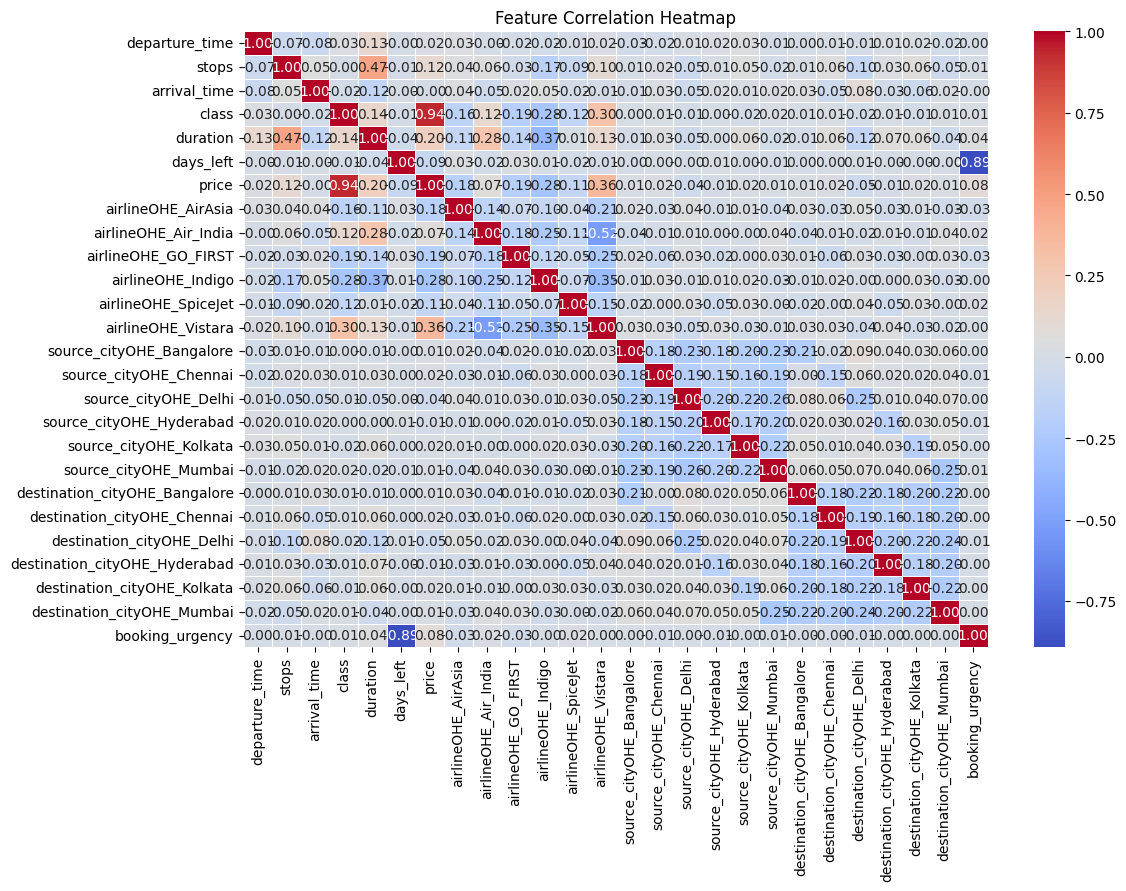

In [ ]:
# Apply the transformer
transformer = FlightEncodingTransformer(use_new_feature=True)
df_transformed = transformer.fit_transform(flightPathDF)

# Compute correlation matrix
corr_matrix = df_transformed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Show the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

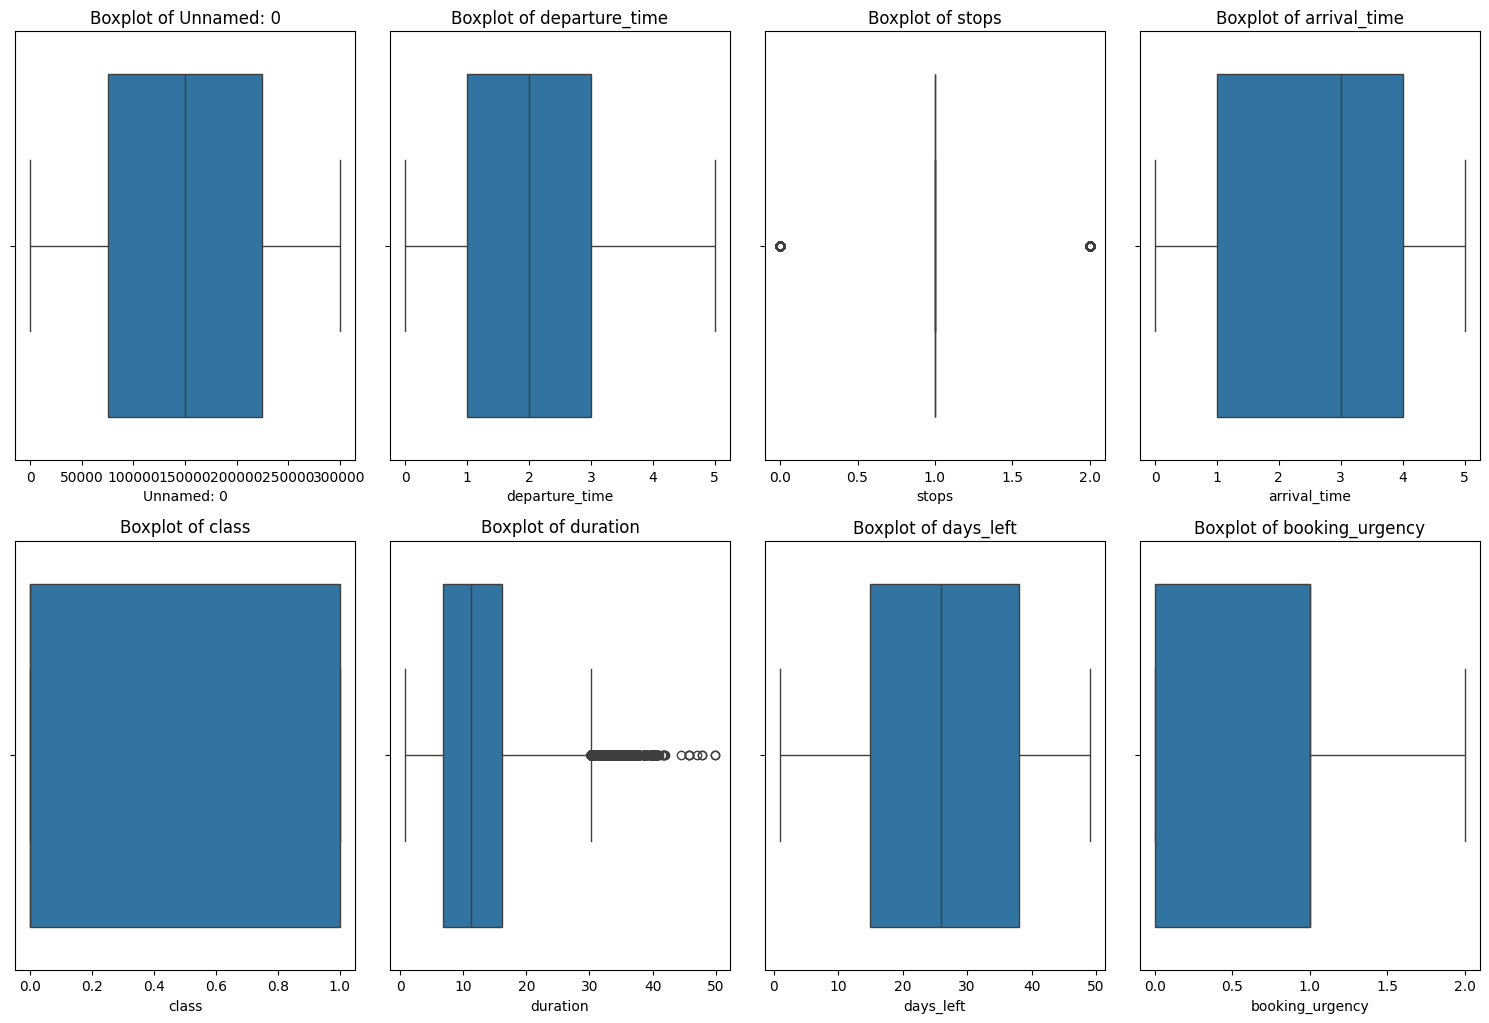

In [ ]:
def plot_combined_boxplots(df):
  numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
  numerical_features = [feature for feature in numerical_features if feature != 'price']  # Exclude price column
  num_features = len(numerical_features)

  fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=4, figsize=(15, 5 * ((num_features // 3) + 1)))
  axes = axes.flatten()

  for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

df_transformed = FlightEncodingTransformer().fit_transform(data)
plot_combined_boxplots(df_transformed)

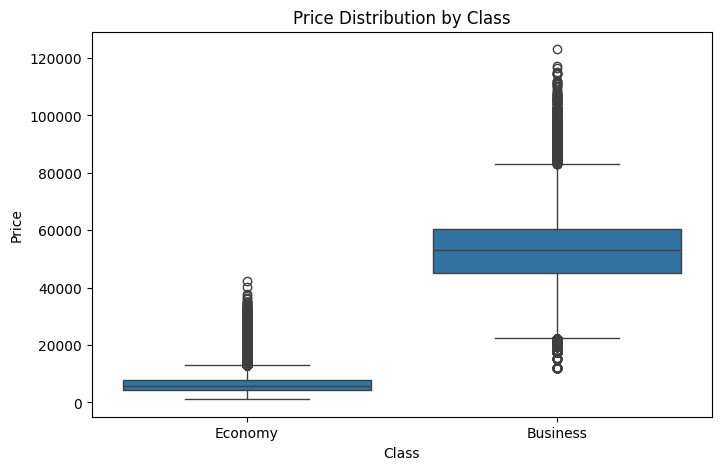

In [ ]:
# Assuming df is your dataset with transformed 'class' and 'price'
plt.figure(figsize=(8, 5))
sns.boxplot(x=flightPathDF['class'], y=flightPathDF['price'])

# Customizations
plt.xticks(ticks=[0, 1], labels=['Economy', 'Business'])
plt.xlabel("Class")
plt.ylabel("Price")
plt.title("Price Distribution by Class")

plt.show()

Splitting Dataset into 80% training and 20% testing

---



In [ ]:
x = flightPathDF.drop("price", axis = 1)
y = flightPathDF["price"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(len(x_train))
print(len(x_test))

240122
60031


Decision Tree
---

---



In [ ]:
pipeline_dt = Pipeline([
  ('preprocessor', FlightEncodingTransformer(use_new_feature=True)),
  ('regressor', DecisionTreeRegressor(random_state=42))
])

pipeline_dt.fit(x_train, y_train)

y_train_pred_dt = pipeline_dt.predict(x_train)
# Training performance
mse_train_dt = mean_squared_error(y_train, y_train_pred_dt)
rmse_train_dt = np.sqrt(mse_train_dt)
mae_train_dt = mean_absolute_error(y_train, y_train_pred_dt)
r2_train_dt = r2_score(y_train, y_train_pred_dt)

# Predictions on test set
y_test_pred_dt = pipeline_dt.predict(x_test)

# Test performance
mse_test_dt = mean_squared_error(y_test, y_test_pred_dt)
rmse_test_dt = np.sqrt(mse_test_dt)
mae_test_dt = mean_absolute_error(y_test, y_test_pred_dt)
r2_test_dt = r2_score(y_test, y_test_pred_dt)

In [ ]:
# Print training and test performance metrics
print(f'---Decision Tree Model Performance---')
print(f"Train MSE: {mse_train_dt}, Test MSE: {mse_test_dt}")
print(f"Train RMSE: {rmse_train_dt}, Test RMSE: {rmse_test_dt}")
print(f"Train MAE: {mae_train_dt}, Test MAE: {mae_test_dt}")
print(f"Train R-Squared: {r2_train_dt}, Test R-Squared: {r2_test_dt}")

---Decision Tree Model Performance---
Train MSE: 367483.561935183, Test MSE: 12487866.13988143
Train RMSE: 606.2042246101416, Test RMSE: 3533.817502345223
Train MAE: 58.31496489284614, Test MAE: 1169.5377832564286
Train R-Squared: 0.9992865963348827, Test R-Squared: 0.9757744023796913


In [ ]:
# Hyper parameter tuning
param_grid_dt = {
  'preprocessor__use_new_feature': [True, False],
  'regressor__max_depth': [None, 5, 10],
  'regressor__min_samples_split': [15, 20, 25],
  'regressor__min_samples_leaf': [1, 2, 4, 10]
}

random_search_dt = RandomizedSearchCV(pipeline_dt, param_grid_dt, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
random_search_dt.fit(x_train, y_train)

print("Best parameters found: ", random_search_dt.best_params_)

pipeline_dt_updated = random_search_dt.best_estimator_

# grid_search = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(x_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

# pipeline_dt_updated = grid_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found:  {'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None, 'preprocessor__use_new_feature': True}


In [ ]:
# Predictions on training set after tuning
y_train_pred_updated_dt = pipeline_dt_updated.predict(x_train)

# Training performance after tuning
mse_train_updated_dt = mean_squared_error(y_train, y_train_pred_updated_dt)
rmse_train_updated_dt = np.sqrt(mse_train_updated_dt)
mae_train_updated_dt = mean_absolute_error(y_train, y_train_pred_updated_dt)
r2_train_updated_dt = r2_score(y_train, y_train_pred_updated_dt)

# Test performance after tuning
y_pred_updated_dt = pipeline_dt_updated.predict(x_test)
mse_updated_dt = mean_squared_error(y_test, y_pred_updated_dt)
rmse_updated_dt = np.sqrt(mse_updated_dt)
mae_updated_dt = mean_absolute_error(y_test, y_pred_updated_dt)
r2_updated_dt = r2_score(y_test, y_pred_updated_dt)

In [ ]:
# Print training and test performance metrics after tuning
print(f'---Decision Tree Model Performance (after tuning)---')
print(f"Train MSE: {mse_train_updated_dt}, Test MSE: {mse_updated_dt}")
print(f"Train RMSE: {rmse_train_updated_dt}, Test RMSE: {rmse_updated_dt}")
print(f"Train MAE: {mae_train_updated_dt}, Test MAE: {mae_updated_dt}")
print(f"Train R-Squared: {r2_train_updated_dt}, Test R-Squared: {r2_updated_dt}")

---Decision Tree Model Performance (after tuning)---
Train MSE: 4972764.109819096, Test MSE: 8564914.485124426
Train RMSE: 2229.9695311414225, Test RMSE: 2926.587515370833
Train MAE: 903.0838983146652, Test MAE: 1196.9948117024817
Train R-Squared: 0.9903462671281763, Test R-Squared: 0.9833846575832251


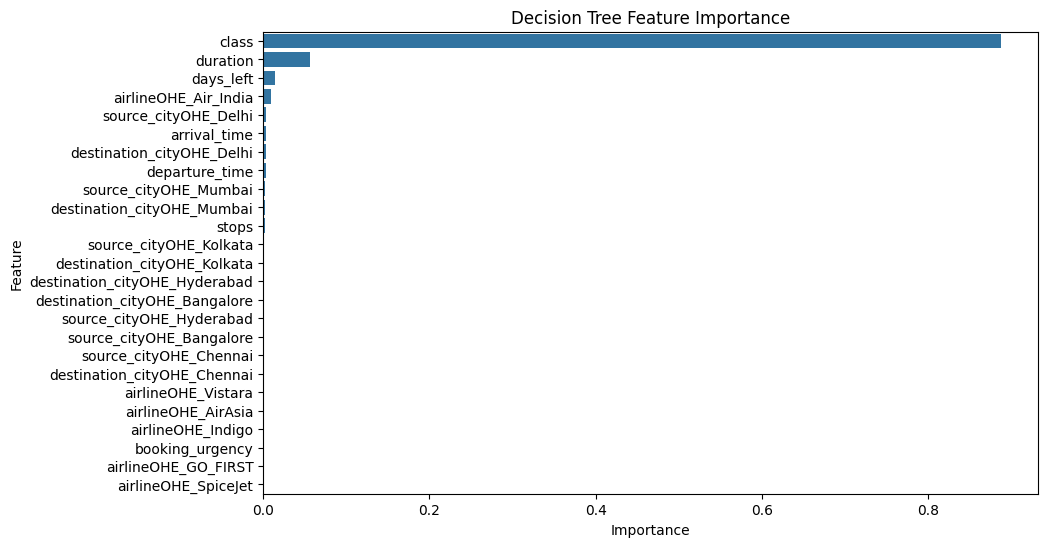

                          Feature  Importance
3                           class    0.888045
4                        duration    0.056964
5                       days_left    0.014098
7            airlineOHE_Air_India    0.009574
14           source_cityOHE_Delhi    0.004019
2                    arrival_time    0.003768
20      destination_cityOHE_Delhi    0.003511
0                  departure_time    0.003194
17          source_cityOHE_Mumbai    0.002325
23     destination_cityOHE_Mumbai    0.001832
1                           stops    0.001827
16         source_cityOHE_Kolkata    0.001575
22    destination_cityOHE_Kolkata    0.001489
21  destination_cityOHE_Hyderabad    0.001452
18  destination_cityOHE_Bangalore    0.001174
15       source_cityOHE_Hyderabad    0.001133
12       source_cityOHE_Bangalore    0.001068
13         source_cityOHE_Chennai    0.000940
19    destination_cityOHE_Chennai    0.000632
11             airlineOHE_Vistara    0.000483
6              airlineOHE_AirAsia 

In [ ]:
# Checking on feature importance affecting the price of flight
importances = pipeline_dt_updated.named_steps['regressor'].feature_importances_

feature_names = pipeline_dt_updated.named_steps['preprocessor'].transform(x_train).columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Decision Tree Feature Importance')
plt.show()

print(importance_df)

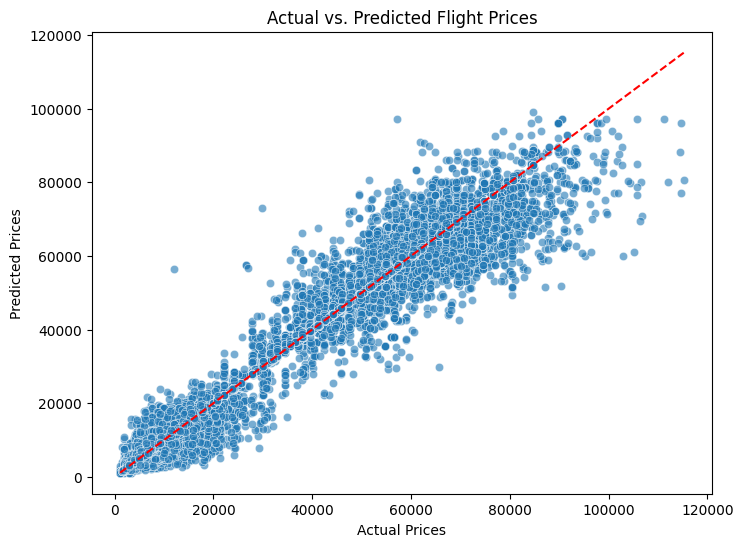

In [ ]:
# Scatter plot of Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_updated_dt, alpha=0.6)  # alpha for transparency
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Flight Prices")
plt.show()

Random Forest Regressor
---

---





In [ ]:
pipeline_rf = Pipeline([
  ('preprocessor', FlightEncodingTransformer(use_new_feature=True)),
  ('regressor', RandomForestRegressor(random_state=42, warm_start=True))
])

pipeline_rf.fit(x_train, y_train)

y_train_pred_rf = pipeline_rf.predict(x_train)
# Training performance
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Predictions on test set
y_test_pred_rf = pipeline_rf.predict(x_test)

# Test performance
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

In [ ]:
# Print training and test performance metrics
print(f'---Random Forest Model Performance---')
print(f"Train MSE: {mse_train_rf}, Test MSE: {mse_test_rf}")
print(f"Train RMSE: {rmse_train_rf}, Test RMSE: {rmse_test_rf}")
print(f"Train MAE: {mae_train_rf}, Test MAE: {mae_test_rf}")
print(f"Train R-Squared: {r2_train_rf}, Test R-Squared: {r2_test_rf}")

---Random Forest Model Performance---
Train MSE: 1275249.304636706, Test MSE: 7778260.98517456
Train RMSE: 1129.269367616383, Test RMSE: 2788.953385263827
Train MAE: 419.67964542303434, Test MAE: 1084.1099429093908
Train R-Squared: 0.9975243313658027, Test R-Squared: 0.9849107110292604


In [ ]:
# Hyper parameter tuning
param_grid_rf = {
  'preprocessor__use_new_feature': [True, False],
  'regressor__n_estimators': [50, 100],
  'regressor__max_depth': [None, 10, 20],
  'regressor__min_samples_split': [2, 5],
  'regressor__min_samples_leaf': [1, 2]
}

random_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, n_iter=10, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
random_search_rf.fit(x_train, y_train)

print("Best parameters found: ", random_search_rf.best_params_)

pipeline_rf_updated = random_search_rf.best_estimator_

# grid_search = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(x_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

# pipeline_rf_updated = grid_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None, 'preprocessor__use_new_feature': True}


In [ ]:
# Predictions on training set after tuning
y_train_pred_updated_rf = pipeline_rf_updated.predict(x_train)

# Training performance after tuning
mse_train_updated_rf = mean_squared_error(y_train, y_train_pred_updated_rf)
rmse_train_updated_rf = np.sqrt(mse_train_updated_rf)
mae_train_updated_rf = mean_absolute_error(y_train, y_train_pred_updated_rf)
r2_train_updated_rf = r2_score(y_train, y_train_pred_updated_rf)

# Test performance after tuning
y_pred_updated_rf = pipeline_rf_updated.predict(x_test)
mse_updated_rf = mean_squared_error(y_test, y_pred_updated_rf)
rmse_updated_rf = np.sqrt(mse_updated_rf)
mae_updated_rf = mean_absolute_error(y_test, y_pred_updated_rf)
r2_updated_rf = r2_score(y_test, y_pred_updated_rf)

In [ ]:
# Print training and test performance metrics after tuning
print(f'---Random Forest Model Performance (after tuning)---')
print(f"Train MSE: {mse_train_updated_rf}, Test MSE: {mse_updated_rf}")
print(f"Train RMSE: {rmse_train_updated_rf}, Test RMSE: {rmse_updated_rf}")
print(f"Train MAE: {mae_train_updated_rf}, Test MAE: {mae_updated_rf}")
print(f"Train R-Squared: {r2_train_updated_rf}, Test R-Squared: {r2_updated_rf}")

---Random Forest Model Performance (after tuning)---
Train MSE: 2764799.6840966446, Test MSE: 7272233.183914184
Train RMSE: 1662.768680272949, Test RMSE: 2696.7078417793396
Train MAE: 658.3185060314751, Test MAE: 1096.0525567422424
Train R-Squared: 0.9946326354910604, Test R-Squared: 0.9858923700061191


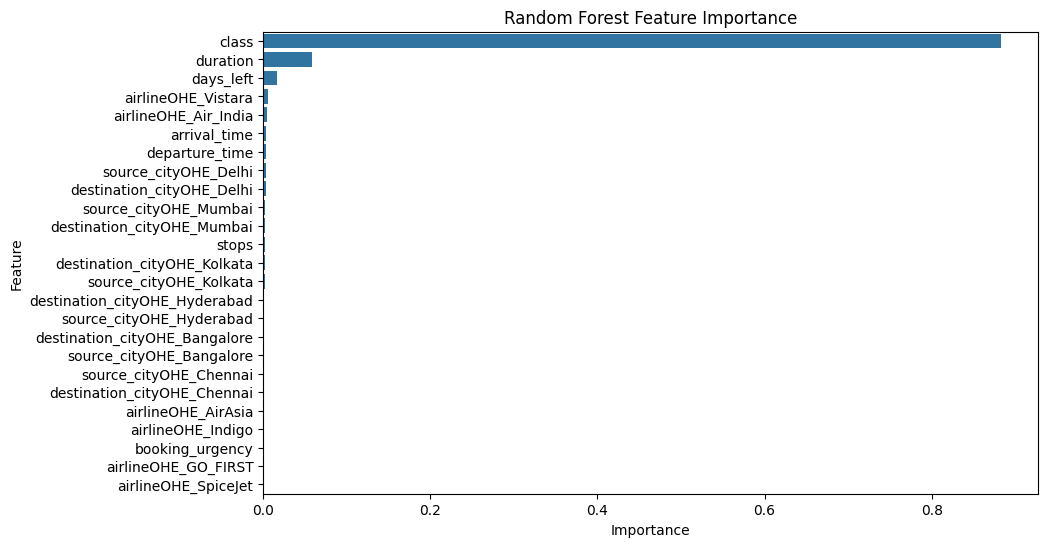

                          Feature  Importance
3                           class    0.883226
4                        duration    0.058299
5                       days_left    0.016359
11             airlineOHE_Vistara    0.005417
7            airlineOHE_Air_India    0.004578
2                    arrival_time    0.003896
0                  departure_time    0.003840
14           source_cityOHE_Delhi    0.003789
20      destination_cityOHE_Delhi    0.003435
17          source_cityOHE_Mumbai    0.002245
23     destination_cityOHE_Mumbai    0.001886
1                           stops    0.001863
22    destination_cityOHE_Kolkata    0.001760
16         source_cityOHE_Kolkata    0.001648
21  destination_cityOHE_Hyderabad    0.001516
15       source_cityOHE_Hyderabad    0.001256
18  destination_cityOHE_Bangalore    0.001221
12       source_cityOHE_Bangalore    0.001075
13         source_cityOHE_Chennai    0.000852
19    destination_cityOHE_Chennai    0.000794
6              airlineOHE_AirAsia 

In [ ]:
# Checking on feature importance affecting the price of flight
importances = pipeline_rf_updated.named_steps['regressor'].feature_importances_

feature_names = pipeline_rf_updated.named_steps['preprocessor'].transform(x_train).columns

importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_rf = importance_rf.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf)
plt.title('Random Forest Feature Importance')
plt.show()

print(importance_rf)

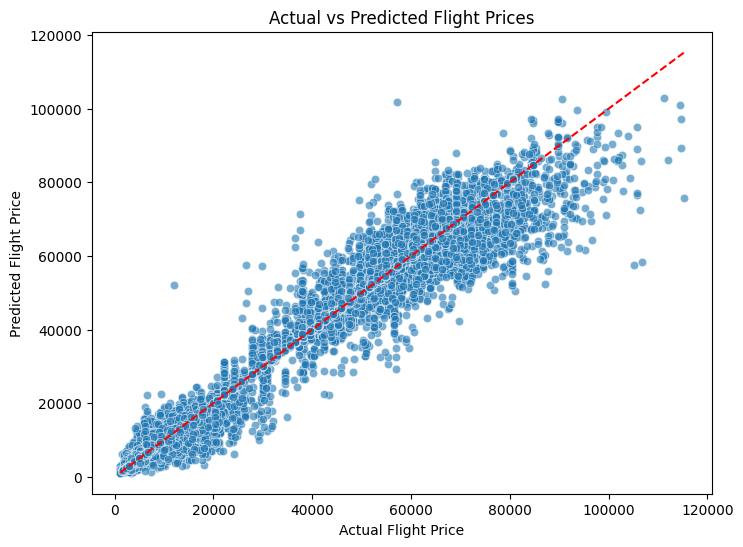

In [ ]:
# Scatter plot of Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_updated_rf, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Flight Price")
plt.ylabel("Predicted Flight Price")
plt.title("Actual vs Predicted Flight Prices")
plt.show()

Gradient Boosted Regressor
---
---

In [ ]:
pipeline_gbm = Pipeline([
  ('preprocessor', FlightEncodingTransformer(use_new_feature=True)),
  ('scaler', StandardScaler()),
  ('regressor', GradientBoostingRegressor(random_state=42))
])

pipeline_gbm.fit(x_train, y_train)

y_train_pred_gbm = pipeline_gbm.predict(x_train)
# Training pegbmormance
mse_train_gbm = mean_squared_error(y_train, y_train_pred_gbm)
rmse_train_gbm = np.sqrt(mse_train_gbm)
mae_train_gbm = mean_absolute_error(y_train, y_train_pred_gbm)
r2_train_gbm = r2_score(y_train, y_train_pred_gbm)

# Predictions on test set
y_test_pred_gbm = pipeline_gbm.predict(x_test)

# Test pegbmormance
mse_test_gbm = mean_squared_error(y_test, y_test_pred_gbm)
rmse_test_gbm = np.sqrt(mse_test_gbm)
mae_test_gbm = mean_absolute_error(y_test, y_test_pred_gbm)
r2_test_gbm = r2_score(y_test, y_test_pred_gbm)

In [ ]:
# Print training and test pegbmormance metrics
print(f'---Gradient Boosted Model Performance---')
print(f"Train MSE: {mse_train_gbm}, Test MSE: {mse_test_gbm}")
print(f"Train RMSE: {rmse_train_gbm}, Test RMSE: {rmse_test_gbm}")
print(f"Train MAE: {mae_train_gbm}, Test MAE: {mae_test_gbm}")
print(f"Train R-Squared: {r2_train_gbm}, Test R-Squared: {r2_test_gbm}")

---Gradient Boosted Model Performance---
Train MSE: 24434939.023898583, Test MSE: 24930672.377802063
Train RMSE: 4943.170948277895, Test RMSE: 4993.06242478522
Train MAE: 2934.788310299176, Test MAE: 2937.7596378768762
Train R-Squared: 0.952563932479677, Test R-Squared: 0.9516362178563428


In [ ]:
# Hyper parameter tuning
param_grid_gbm = {
  'preprocessor__use_new_feature': [True, False],
  'regressor__n_estimators': [100, 200, 300],
  'regressor__learning_rate': [0.01, 0.1, 0.2],
  'regressor__max_depth': [3, 5, 7]
}

random_search_gbm = RandomizedSearchCV(pipeline_gbm, param_grid_gbm, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
random_search_gbm.fit(x_train, y_train)

print("Best parameters found: ", random_search_gbm.best_params_)

pipeline_gbm_updated = random_search_gbm.best_estimator_

# grid_search = GridSearchCV(pipeline_gbm, param_grid_gbm, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(x_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

# pipeline_gbm_updated = grid_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found:  {'regressor__n_estimators': 100, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.2, 'preprocessor__use_new_feature': True}


In [ ]:
# Predictions on training set after tuning
y_train_pred_updated_gbm = pipeline_gbm_updated.predict(x_train)

# Training pegbmormance after tuning
mse_train_updated_gbm = mean_squared_error(y_train, y_train_pred_updated_gbm)
rmse_train_updated_gbm = np.sqrt(mse_train_updated_gbm)
mae_train_updated_gbm = mean_absolute_error(y_train, y_train_pred_updated_gbm)
r2_train_updated_gbm = r2_score(y_train, y_train_pred_updated_gbm)

# Test pegbmormance after tuning
y_pred_updated_gbm = pipeline_gbm_updated.predict(x_test)
mse_updated_gbm = mean_squared_error(y_test, y_pred_updated_gbm)
rmse_updated_gbm = np.sqrt(mse_updated_gbm)
mae_updated_gbm = mean_absolute_error(y_test, y_pred_updated_gbm)
r2_updated_gbm = r2_score(y_test, y_pred_updated_gbm)

In [ ]:
# Print training and test pegbmormance metrics after tuning
print(f'---Gradient Boosted Model Performance (after tuning)---')
print(f"Train MSE: {mse_train_updated_gbm}, Test MSE: {mse_updated_gbm}")
print(f"Train RMSE: {rmse_train_updated_gbm}, Test RMSE: {rmse_updated_gbm}")
print(f"Train MAE: {mae_train_updated_gbm}, Test MAE: {mae_updated_gbm}")
print(f"Train R-Squared: {r2_train_updated_gbm}, Test R-Squared: {r2_updated_gbm}")

---Gradient Boosted Model Performance (after tuning)---
Train MSE: 10063427.668333592, Test MSE: 11136187.399709025
Train RMSE: 3172.2906027559316, Test RMSE: 3337.092656746142
Train MAE: 1796.8892159203924, Test MAE: 1870.5070242748118
Train R-Squared: 0.9804636535456843, Test R-Squared: 0.9783965657584903


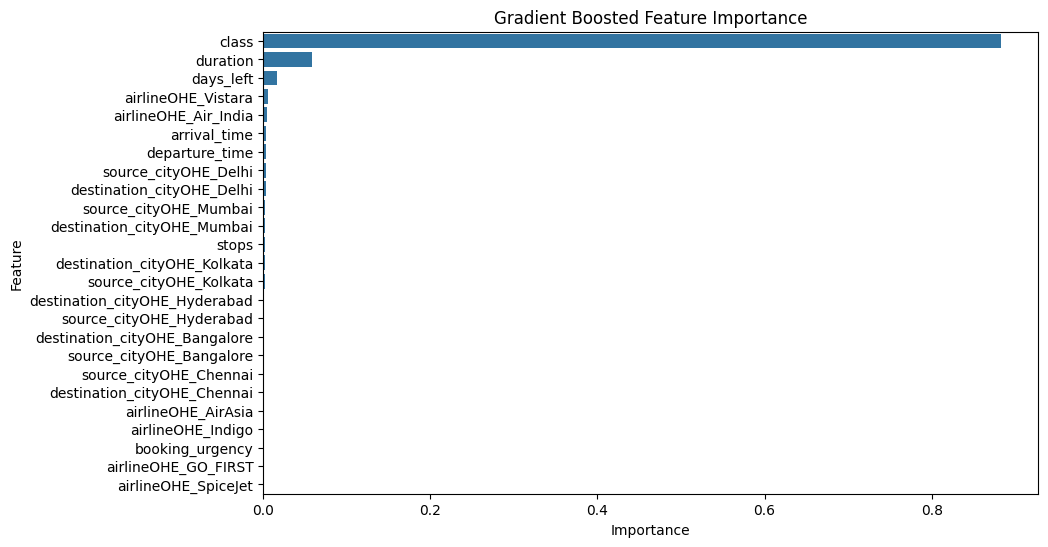

                          Feature  Importance
3                           class    0.899621
4                        duration    0.049292
5                       days_left    0.012452
11             airlineOHE_Vistara    0.009340
20      destination_cityOHE_Delhi    0.003399
14           source_cityOHE_Delhi    0.003221
2                    arrival_time    0.002869
0                  departure_time    0.002211
16         source_cityOHE_Kolkata    0.002071
23     destination_cityOHE_Mumbai    0.002034
22    destination_cityOHE_Kolkata    0.001833
1                           stops    0.001734
7            airlineOHE_Air_India    0.001637
21  destination_cityOHE_Hyderabad    0.001292
15       source_cityOHE_Hyderabad    0.001246
18  destination_cityOHE_Bangalore    0.001208
12       source_cityOHE_Bangalore    0.001104
17          source_cityOHE_Mumbai    0.001071
13         source_cityOHE_Chennai    0.000684
19    destination_cityOHE_Chennai    0.000592
6              airlineOHE_AirAsia 

In [ ]:
# Checking on feature importance affecting the price of flight
importances = pipeline_gbm_updated.named_steps['regressor'].feature_importances_

feature_names = pipeline_gbm_updated.named_steps['preprocessor'].transform(x_train).columns

importance_gbm = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_gbm = importance_gbm.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf)
plt.title('Gradient Boosted Feature Importance')
plt.show()

print(importance_gbm)

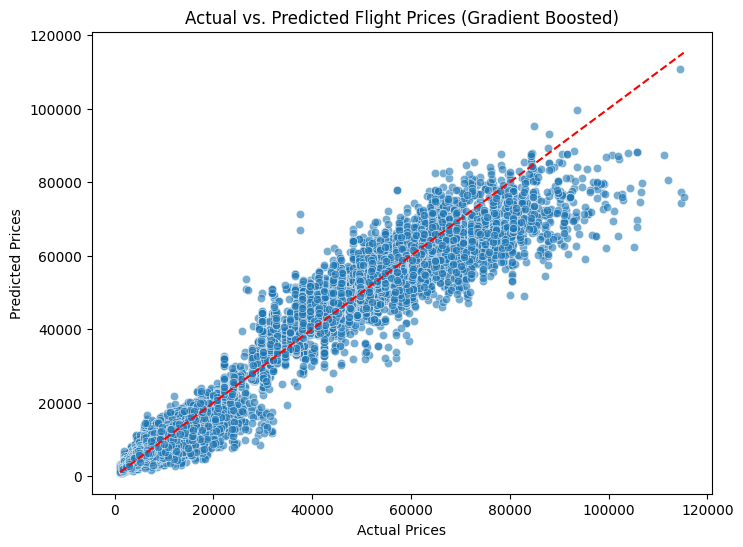

In [ ]:
# Scatter plot of Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_updated_gbm, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Flight Prices (Gradient Boosted)")
plt.show()

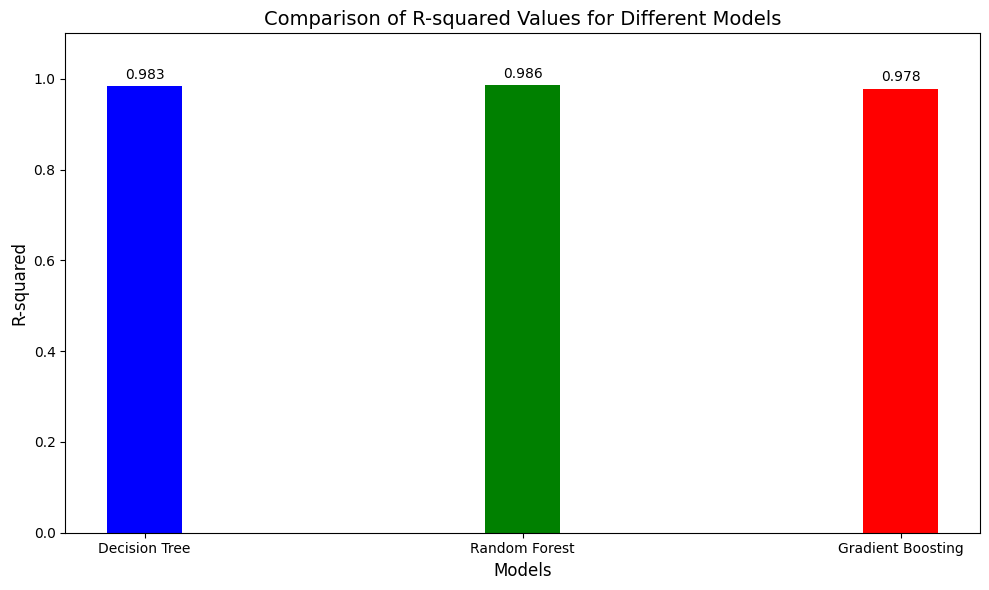

In [ ]:
r2_values = {
  'Decision Tree': r2_updated_dt,
  'Random Forest': r2_updated_rf,
  'Gradient Boosting': r2_updated_gbm
}

models = list(r2_values.keys())
r2_scores = list(r2_values.values())

# Create bar chart with wider spacing between bars
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'green', 'red'], width=0.2)

# Add data labels to the top of each bar
for i, v in enumerate(r2_scores):
  plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom')  # Adjust position as needed

# Customize the chart
plt.xlabel("Models", fontsize=12)
plt.ylabel("R-squared", fontsize=12)
plt.title("Comparison of R-squared Values for Different Models", fontsize=14)
plt.ylim(0, 1.1)  # Adjust for labels
plt.xticks(rotation=0, ha='center')  # Horizontal labels, no rotation

# Display the chart
plt.tight_layout()  # Improve spacing
plt.show()